# TSMO Data Processing - May 3, 2023
1. Read Files
2. Segment Selection - select target TMC segments for input and output
3. Processing for Input Features and Output Ground Truth
    - Raw Speed & Imputation
    - Speed Feature Processing (TTI & SD)
    - Incident Processing
        - Mark as Incident based on (1) Waze & RCRS report and (2) slow down speed
        - Mark as Incident based on Abnormal Speed
        - For output ground truth, mark as incident based on upstream abnormal speed.
    - Density Processing
    - Miscellaneous (weather, time)
    - Concat Input Features Together and Normalize
4. GCN Embedding - Node and Edge Embedding for GCN

In [1]:
pwd

'/Users/haowu/Desktop/Transportation Research/Traffic-Prediction/data_processing/TSMO'

In [2]:
cd ..

/Users/haowu/Desktop/Transportation Research/Traffic-Prediction/data_processing


In [3]:
import csv
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import pickle

from datetime import datetime as dt
from collections import Counter
from scipy.spatial.distance import cdist
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from matplotlib import pyplot as plt

from utils import *

In [16]:
# Hyper-parameters during Data Processing 

# Time
start_date = dt(2022, 2, 14)
end_date = dt(2023, 2, 12)
start_min = 330 # 05:30:00 
end_min = 1260 # 21:00:00
busi_date = pd.bdate_range(start=start_date, end=end_date).date  # 260 business dates

# For Segment Selection
para_na_rate_spd_quantile_threshold_tmc_all = 1
para_na_rate_spd_quantile_threshold_xd = 1

# For incident processing
para_in_inc_spd_quantile_threshold = 0.15
para_out_inc_spd_quantile_threshold = 0.15
para_out_inc_space_limit = 5 # how far we are tracing upstream (5 miles here)
para_out_inc_tti_threshold = 1.6 # how slow the speed is compared with its reference speed (1.6 here)
para_out_inc_lead_time = 30 # how long we are marking in advance (30 min here)

## Part 1. Read Files

### 1.1 TMC Data
- Speed 
    - All (1431 TMC segments with geo-info and upstream segments)
    - PV (584 TMC segments with geo-info and upstream segments)
    - Truck (583 TMC segments with geo-info and upstream segments)
- Density (1431 TMC segments with geo-info and upstream segments)
- Incident (1591 TMC segments with geo-info)

In [5]:
# TMC Speed Data 
# (1) All
df_spd_tmc_1min_all_1431 = pickle.load(open("../data/TSMO/TSMO_df_downsampled_spd_tmc_1min_all.pkl", "rb"))  # (241800, 1431), 1003264 NaN
df_spd_tmc_5min_all_584 = pickle.load(open("../data/TSMO/TSMO_df_downsampled_spd_tmc_5min_all.pkl", "rb"))  # (48360, 584), 8652895 NaN

# (2) Personal Vehicles
df_spd_tmc_5min_pv_584 = pickle.load(open("../data/TSMO/TSMO_df_downsampled_spd_tmc_5min_pv.pkl", "rb"))  # (48360, 584), 10351961 NaN

# (3) Trucks
df_spd_tmc_5min_truck_583 = pickle.load(open("../data/TSMO/TSMO_df_downsampled_spd_tmc_5min_truck.pkl", "rb"))  # (241800, 583), 16851767 NaN

In [26]:
# TMC Density Data 
# (1) All
df_dens_tmc_1min_all_1431 = pickle.load(open("../data/TSMO/TSMO_df_downsampled_dens_tmc_1min_all.pkl", "rb"))  # (241800, 1431), 1003264 NaN
df_dens_tmc_5min_all_584 = pickle.load(open("../data/TSMO/TSMO_df_downsampled_dens_tmc_5min_all.pkl", "rb"))  # (48360, 584), 8652895 NaN

# (2) Personal Vehicles
df_dens_tmc_5min_pv_584 = pickle.load(open("../data/TSMO/TSMO_df_downsampled_dens_tmc_5min_pv.pkl", "rb"))  # (48360, 584), 10351961 NaN

# (3) Trucks
df_dens_tmc_5min_truck_583 = pickle.load(open("../data/TSMO/TSMO_df_downsampled_dens_tmc_5min_truck.pkl", "rb"))  # (241800, 583), 16851767 NaN

# Convert to Ordinal Embedding
df_dens_tmc_1min_all_1431 = df_dens_tmc_1min_all_1431.replace([10., 20., 30.], [1/6, 3/6, 5/6])
df_dens_tmc_5min_all_584 = df_dens_tmc_5min_all_584.replace(["A", "B", "C"], [1/6, 3/6, 5/6])
df_dens_tmc_5min_pv_584 = df_dens_tmc_5min_pv_584.replace(["A", "B", "C"], [1/6, 3/6, 5/6])
df_dens_tmc_5min_truck_583 = df_dens_tmc_5min_truck_583.replace(["A", "B", "C"], [1/6, 3/6, 5/6])

In [7]:
# TMC Incident Data

# Max-gated incident status incorporating multi-source incident information
df_inc_tmc_5min_all_1591 = pickle.load(open("../data/TSMO/TSMO_df_inc_tmc_5min_all.pkl", "rb"))  # (48360, 1591), 0 NaN

# Incident status from Waze record only
df_inc_tmc_5min_waze_1591 = pickle.load(open("../data/TSMO/TSMO_df_inc_tmc_5min_waze.pkl", "rb"))  # (48360, 1591), 0 NaN

### 1.2 XD Data
- Speed (2350 XD segments with geo-info and corresponding TMC segments)
- Density (2350 XD segments with geo-info and corresponding TMC segments)

In [8]:
# XD Speed Data
df_spd_xd_1min_2350 = pickle.load(open("../data/TSMO/TSMO_df_downsampled_spd_xd_1min.pkl", "rb"))  # (241800, 2350), 897419 NaN
df_spd_xd_1min_2350.columns = df_spd_xd_1min_2350.columns.astype(str)

In [9]:
df_spd_xd_1min_2350

xd_id,132900310,132964437,133145030,133193027,133201453,133248799,133286962,133287070,133319826,133354553,...,1310616769,1310617056,1310617058,1310617450,1310617452,1310617873,1310617874,1310617876,1310617877,1310618271
measurement_tstamp,,,,,,,,,,,,,,,,,,,,,
2022-02-14 05:30:00,53.0,23.0,42.0,34.0,28.0,32.0,61.0,42.0,26.0,31.0,...,66.0,35.0,31.0,25.0,16.0,62.0,61.0,57.0,56.0,70.0
2022-02-14 05:31:00,53.0,23.0,42.0,34.0,28.0,32.0,61.0,42.0,26.0,31.0,...,66.0,35.0,31.0,25.0,16.0,60.0,61.0,57.0,56.0,70.0
2022-02-14 05:32:00,52.0,23.0,42.0,34.0,28.0,30.0,61.0,42.0,26.0,31.0,...,66.0,35.0,32.0,25.0,16.0,60.0,61.0,57.0,56.0,70.0
2022-02-14 05:33:00,52.0,23.0,42.0,34.0,27.0,30.0,61.0,42.0,26.0,31.0,...,65.0,35.0,32.0,25.0,16.0,60.0,61.0,57.0,56.0,69.0
2022-02-14 05:34:00,52.0,23.0,42.0,34.0,27.0,30.0,61.0,42.0,26.0,31.0,...,65.0,35.0,32.0,25.0,16.0,60.0,61.0,57.0,56.0,71.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-10 20:55:00,46.0,24.0,41.0,34.0,23.0,24.0,50.0,29.0,27.0,42.0,...,60.0,29.0,30.0,26.0,24.0,67.0,67.0,66.0,68.0,70.0
2023-02-10 20:56:00,46.0,24.0,41.0,34.0,23.0,24.0,50.0,31.0,27.0,42.0,...,60.0,28.0,30.0,26.0,24.0,66.0,66.0,66.0,64.0,71.0
2023-02-10 20:57:00,46.0,24.0,41.0,34.0,23.0,25.0,50.0,38.0,27.0,42.0,...,60.0,27.0,30.0,26.0,24.0,66.0,66.0,68.0,63.0,71.0


In [10]:
# XD Density Data
df_dens_xd_1min_2350 = pickle.load(open("../data/TSMO/TSMO_df_downsampled_dens_xd_1min.pkl", "rb"))  # (241800, 2350), 897419 NaN
df_dens_xd_1min_2350.columns = df_dens_xd_1min_2350.columns.astype(str)

### 1.3 Geo Data
- Shapefile (used for visualization)
- Geographical Correspondence between TMC & XD
- Upstream Segments within 5 Miles (used for slowdown speed calculation and incident feature processing)

In [11]:
# Shape
gdf_tmc = gpd.read_file("../data/TSMO/TSMO_tmc_shape/TSMO_tmc_shape_for_sjoin.geojson")  # 1591 TMC segments in TSMO (selected from Carroll, Howard and Baltimore) used for spatial join
gdf_tmc = gdf_tmc.rename(columns={"tmc":"id_tmc", "miles":"miles_tmc"})

gdf_xd = gpd.read_file("../data/TSMO/TSMO_xd_shape/TSMO_xd_shape_for_sjoin.geojson")  # 2501 XD segments in TSMO (selected from Carroll, Howard and Baltimore) used for spatial join
gdf_xd = gdf_xd.rename(columns={"XDSegID":"id_xd_str", "PreviousXD":"id_xd_prev", "NextXDSegI":"id_xd_next", "Miles":"miles_xd"})

In [12]:
# Geographical Correspondence between TMC and XD
dict_tmc_xd_join = pickle.load(open("../data/TSMO/TSMO_dict_xd_to_tmc.pkl", "rb"))  # 1555 TMC matched with 2427 XD

In [166]:
# Immediate Previous Neighbor Segment
dict_prev_tmc = pickle.load(open("../data/TSMO/TSMO_dict_prev_tmc.pkl", "rb"))

In [13]:
# Upstream Segments within 5 Miles
dict_upstream_unique_tmc_5mile = pickle.load(open("../data/TSMO/TSMO_dict_upstream_unique_tmc_5_miles.pkl", "rb"))  # 1591 TMC segments, 158 of which doesn't have any upstream neighbors

In [14]:
# Set of 2350 XD Segments with Geo-info, Speed and Corresponding TMC segments
set_xd_segments_str_within_spd_shp_match = set([str(xd) for xd in df_spd_xd_1min_2350.columns])

## Part 2. Segment Selection for Input & Output

- We select target TMC segments based on 
    - speed data 
    - geo data
    - incident data
- There are two steps involved:
    1. Imputation of 1/5-min Speed Data based on TMC/XD Speed Data (1/5-min)
    2. Selection of TMC segments:
        - Covered by all of three data sources: 5-min Speed (with appropriate NaN rate), Geo, Incident
        - Have upstream segments


### 2.1 Imputation on Raw Speed

In [15]:
# takes ~50 min to execute
# 1. Impute 1-min TMC speed data of all vehicles with 1-min XD speed data
count = 0
for tmc in tqdm(df_spd_tmc_1min_all_1431.columns):
    if tmc in dict_tmc_xd_join:
        # there are 28 TMC segments that don't have any corresponding XD in df_spd_xd_1min_2350.
        # corresponding_xd = [xd for xd in dict_tmc_xd_join[tmc] if xd in df_spd_xd_1min_2350.columns] 
        corresponding_xd = list(set(dict_tmc_xd_join[tmc]).intersection(set_xd_segments_str_within_spd_shp_match))
        if len(corresponding_xd) == 0:
            count += 1
            continue
        df_spd_tmc_1min_all_1431[tmc] = df_spd_tmc_1min_all_1431[tmc].fillna(df_spd_xd_1min_2350[corresponding_xd].mean(axis=1))

# df_spd_tmc_1min_all_1431 now has 543005 NaN (reduced from 1003264 NaN)

100%|██████████| 1431/1431 [49:30<00:00,  2.08s/it] 


In [18]:
# Aggregate 1-min TMC speed data of all vehicles to 5-min for imputation use
df_spd_tmc_5min_all_1431 = df_spd_tmc_1min_all_1431.resample("5 min").mean() 
df_spd_tmc_5min_all_1431 = df_spd_tmc_5min_all_1431[pd.Index(df_spd_tmc_5min_all_1431.index.date).isin(busi_date)]
df_spd_tmc_5min_all_1431 = df_spd_tmc_5min_all_1431[(df_spd_tmc_5min_all_1431.index.hour * 60 + df_spd_tmc_5min_all_1431.index.minute >= start_min ) & (df_spd_tmc_5min_all_1431.index.hour * 60 + df_spd_tmc_5min_all_1431.index.minute < end_min)]  # 5-min frequency, (260 * 186, 1000), 177267 NaN
# (48360, 1431), 78230 NaN

In [22]:
# 2. Impute 5-min TMC speed data of all vehicles with aggregated 5-min TMC speed data of all vehicles
count = 0
for tmc in tqdm(df_spd_tmc_5min_all_584.columns):
    # all TMC segments in df_spd_tmc_5min_all_584 are covered in df_spd_tmc_5min_all_1431
    if tmc not in df_spd_tmc_5min_all_1431.columns:
        count += 1
    else:
        df_spd_tmc_5min_all_584[tmc] = df_spd_tmc_5min_all_584[tmc].fillna(df_spd_tmc_5min_all_1431[tmc])

# df_spd_tmc_5min_all_584 now has 30274 NaN (reduced from 8652895 NaN)

100%|██████████| 584/584 [00:10<00:00, 57.24it/s] 


In [24]:
# check for NaN rate of imputed 5-min speed data of 584 TMC segments
na_rate_spd_tmc_5min_all = df_spd_tmc_5min_all_584.isna().mean()
print(na_rate_spd_tmc_5min_all.describe(), na_rate_spd_tmc_5min_all.quantile(q=para_na_rate_spd_quantile_threshold_tmc_all))

count    584.000000
mean       0.001072
std        0.017616
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000021
max        0.301406
dtype: float64 0.30140612076095946


**\[Observation\]**

Now the imputed 5-min speed data of 584 TMC segments has fairly low NaN rate among nearly all 584 segments. 

Therefore, we don't get rid of any TMC segments.

In [27]:
# 3. Impute 5-min TMC speed data internally (all, pv, truck)
df_spd_ratio_tmc_5min_pv_vs_all = df_spd_tmc_5min_pv_584.divide(df_spd_tmc_5min_all_584)
df_spd_ratio_tmc_5min_pv_vs_all[df_spd_ratio_tmc_5min_pv_vs_all == np.inf] = np.nan
df_spd_tmc_5min_pv_584 = df_spd_tmc_5min_pv_584.fillna(df_spd_tmc_5min_all_584*df_spd_ratio_tmc_5min_pv_vs_all.mean(axis=0))  # 30274 NaN

df_spd_ratio_tmc_5min_truck_vs_all = df_spd_tmc_5min_truck_583.divide(df_spd_tmc_5min_all_584)
df_spd_ratio_tmc_5min_truck_vs_all[df_spd_ratio_tmc_5min_truck_vs_all == np.inf] = np.nan
df_spd_tmc_5min_truck_583 = df_spd_tmc_5min_truck_583.fillna(df_spd_tmc_5min_all_584*df_spd_ratio_tmc_5min_truck_vs_all.mean(axis=0))  # 30272 NaN

In [29]:
print(df_spd_tmc_5min_pv_584.isna().mean().describe())
print(df_spd_tmc_5min_truck_583.isna().mean().describe())

count    584.000000
mean       0.001072
std        0.017616
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000021
max        0.301406
dtype: float64
count    583.000000
mean       0.001074
std        0.017631
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000021
max        0.301406
dtype: float64


### 2.2 Selection of TMC Segments

In [30]:
# 583 Target TMC Segments
set_target_tmc = set(df_spd_tmc_5min_all_584.columns).intersection(set(df_spd_tmc_5min_pv_584.columns)).intersection(set(df_spd_tmc_5min_truck_583.columns)) # 583 target TMC segments

list_target_tmc = list(set_target_tmc)

<AxesSubplot: title={'center': 'Visualization of Eventually Selected Target TMC (blue, 583) Segments'}>

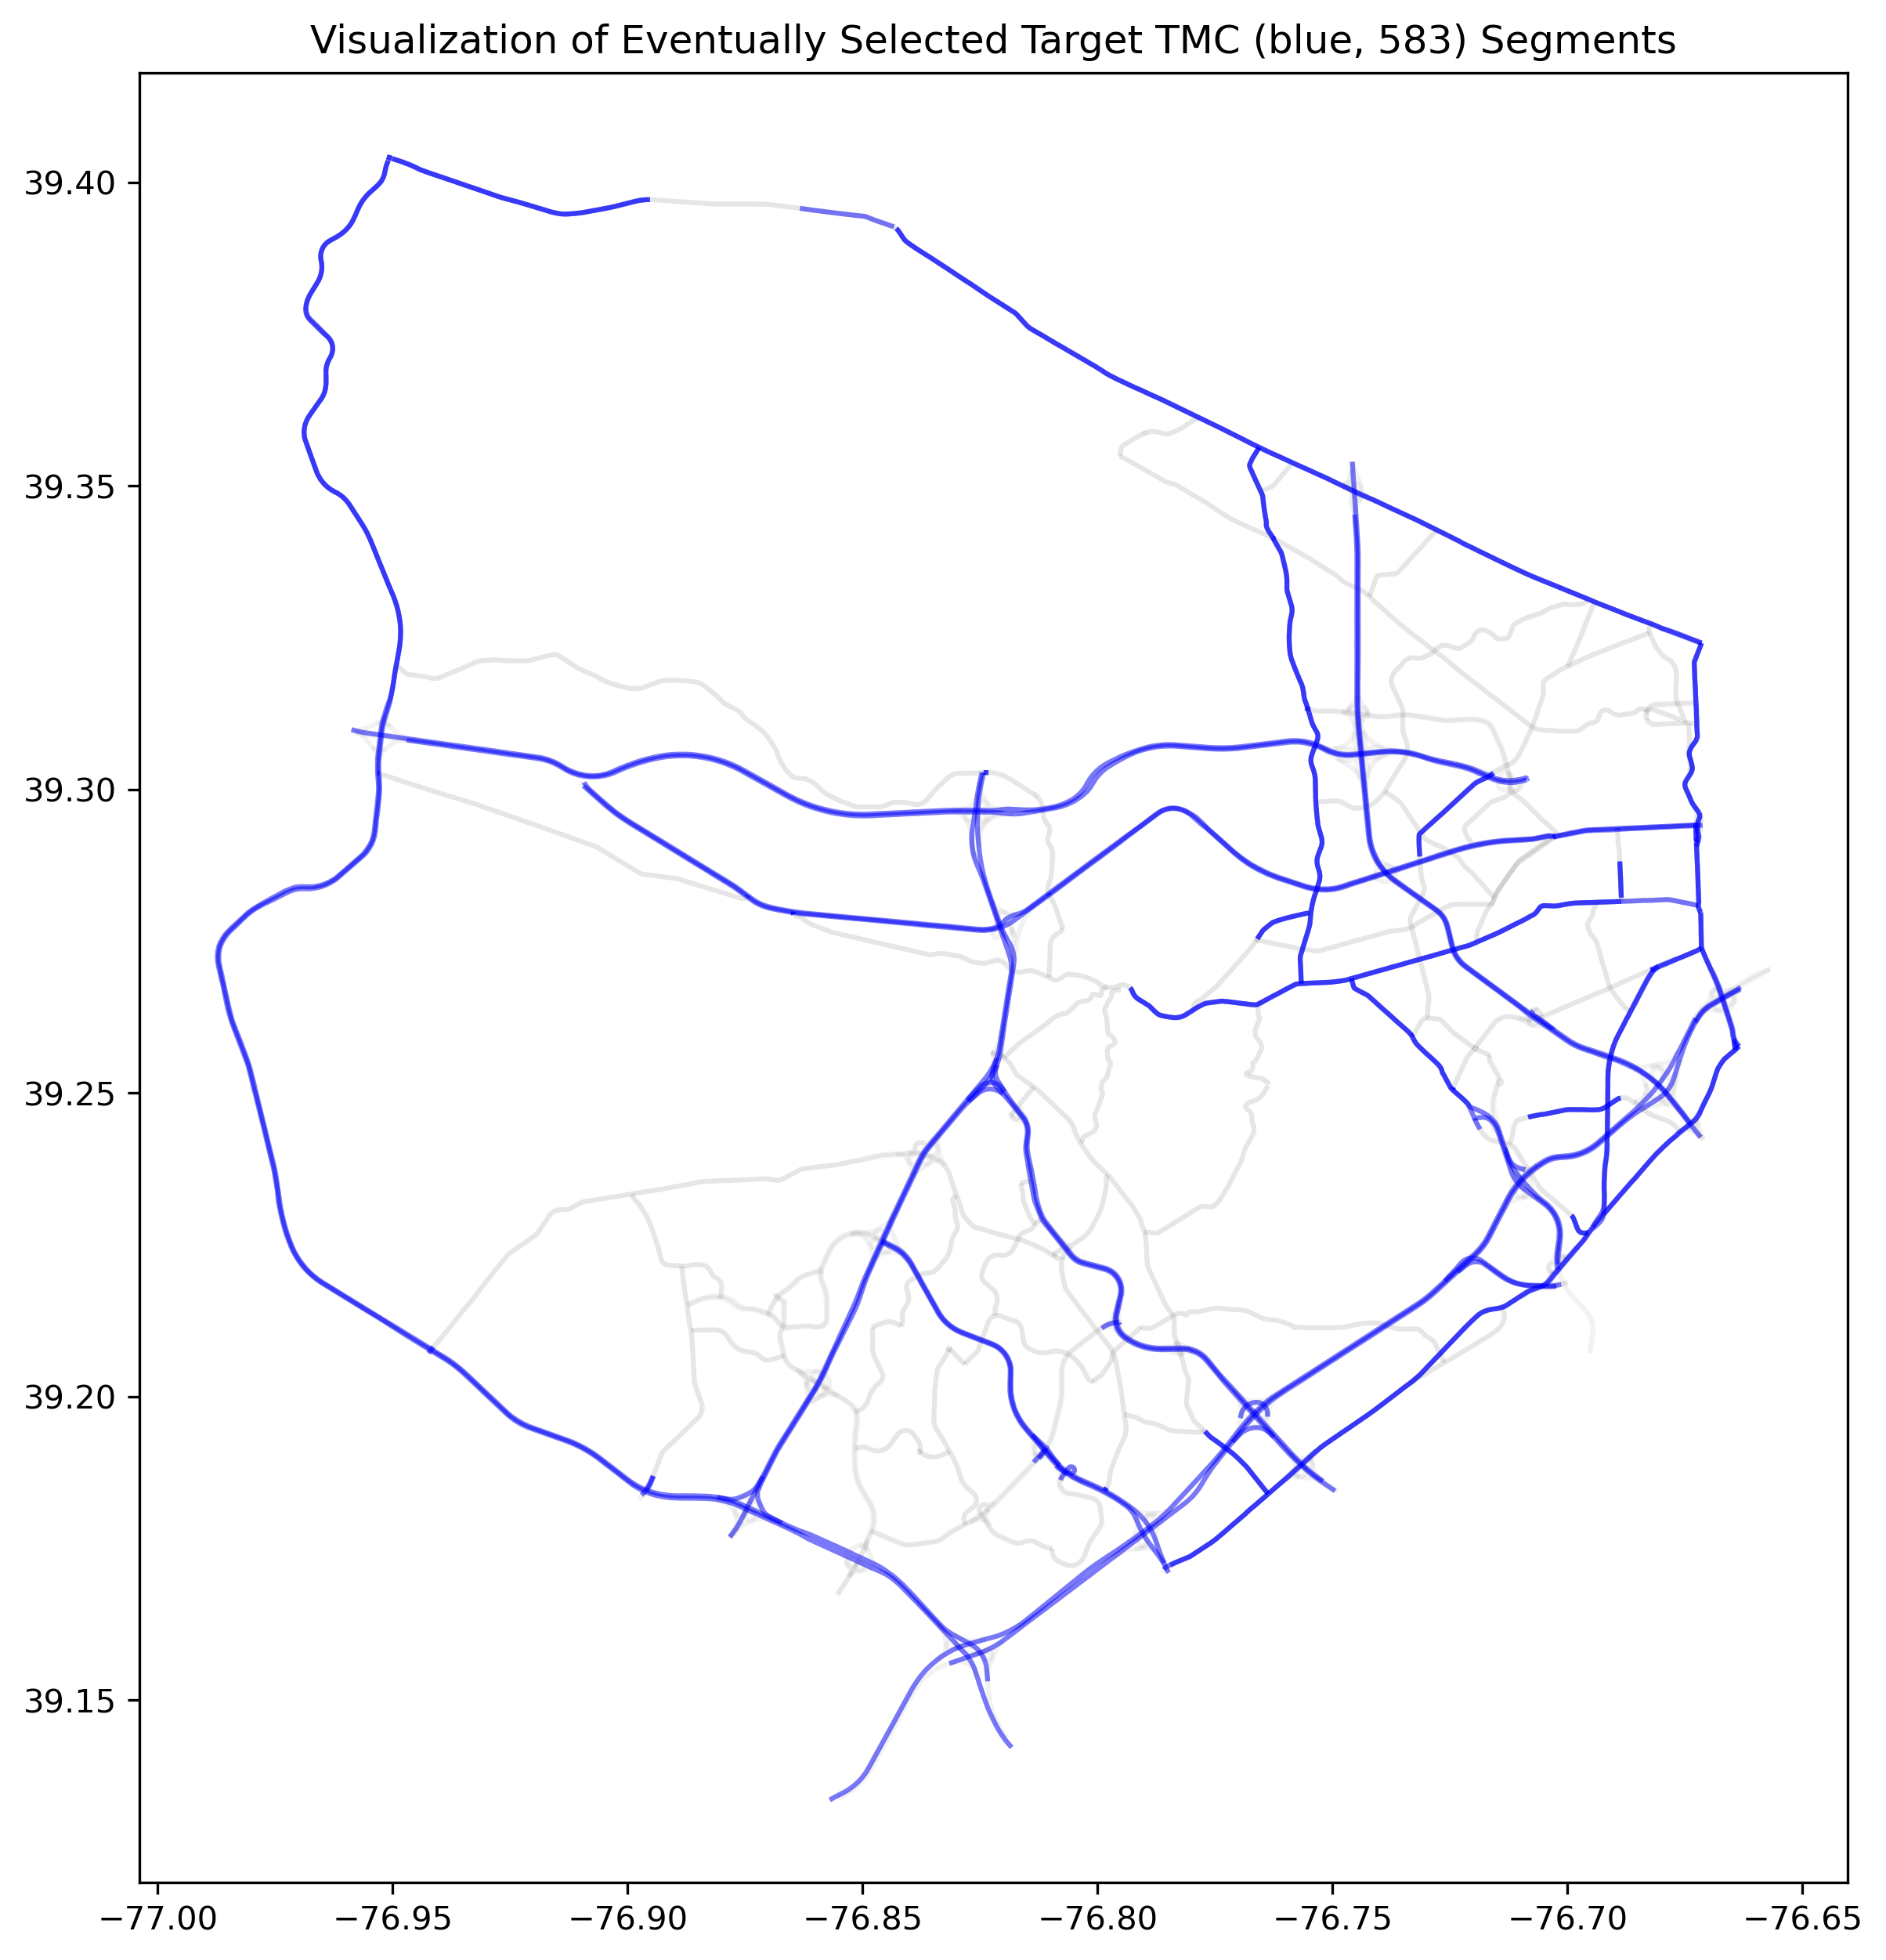

In [32]:
# fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
fig, ax = plt.subplots(1,figsize=(15,10), dpi=300)
ax.set_title("Visualization of Eventually Selected Target TMC (blue, 583) Segments")
gdf_tmc.plot(ax=ax, color="grey", alpha=0.1) # TMC segments in TSMO
gdf_tmc[gdf_tmc.id_tmc.isin(set_target_tmc)].plot(ax=ax, color="blue", alpha=0.5)  # 583 finalized TMC target segments

## Part 3. Processing of Input Features and Output Ground Truth
1. Raw Speed (Imputation)
2. Speed Features
    - Time of Travel Index (TTI)
    - Slowdown Speed (SD)
4. Incident
5. Density
5. Miscellaneous
    - Weather & Time
    - Generation of Final Input Features & Output Ground Truth

### 3.1 Raw Speed

#### 3.1.1 Imputation
Note - Here I first include speed data from 05:30:00~20:55:00. In the sections afterwards, I will extract input feature (05:30:00~20:25:00) and output ground truth (06:00:00~20:55:00)

In [33]:
df_spd_tmc_5min_all_583 = df_spd_tmc_5min_all_584[list_target_tmc]  # shape (48360, 583), 30272 NaN
df_spd_tmc_5min_pv_583 = df_spd_tmc_5min_pv_584[list_target_tmc]  # shape (48360, 583), 30272 NaN
# df_spd_tmc_5min_truck_583 remains the same

In [38]:
df_spd_tmc_5min_all_583 = df_spd_tmc_5min_all_583.fillna(method='ffill')  # 755 NaN
df_spd_tmc_5min_pv_583 = df_spd_tmc_5min_pv_583.fillna(method='ffill')  # 755 NaN
df_spd_tmc_5min_truck_583 = df_spd_tmc_5min_truck_583.fillna(method='ffill')  # 755 NaN

df_spd_tmc_5min_all_583 = df_spd_tmc_5min_all_583.fillna(method='bfill')  # 0 NaN
df_spd_tmc_5min_pv_583 = df_spd_tmc_5min_pv_583.fillna(method='bfill')  # 0 NaN
df_spd_tmc_5min_truck_583 = df_spd_tmc_5min_truck_583.fillna(method='bfill')  # 0 NaN

In [44]:
# Save speed data (containing data of both input and output)
pickle.dump(df_spd_tmc_5min_all_583, open("../data/TSMO/TSMO_df_spd_tmc_5min_all_583.pkl", "wb"))
pickle.dump(df_spd_tmc_5min_pv_583, open("../data/TSMO/TSMO_df_spd_tmc_5min_pv_583.pkl", "wb"))
pickle.dump(df_spd_tmc_5min_truck_583, open("../data/TSMO/TSMO_df_spd_tmc_5min_truck_583.pkl", "wb"))

#### 3.1.2 Separate Input & Output and Save Speed Data into Files

In [40]:
df_in_spd_tmc_5min_all = df_spd_tmc_5min_all_583[(df_spd_tmc_5min_all_583.index.hour * 60 + df_spd_tmc_5min_all_583.index.minute >= start_min ) & (df_spd_tmc_5min_all_583.index.hour * 60 + df_spd_tmc_5min_all_583.index.minute < end_min-30)]  #(46800, 583)
df_in_spd_tmc_5min_pv = df_spd_tmc_5min_pv_583[(df_spd_tmc_5min_pv_583.index.hour * 60 + df_spd_tmc_5min_pv_583.index.minute >= start_min ) & (df_spd_tmc_5min_pv_583.index.hour * 60 + df_spd_tmc_5min_pv_583.index.minute < end_min-30)]  #(46800, 583)
df_in_spd_tmc_5min_truck = df_spd_tmc_5min_truck_583[(df_spd_tmc_5min_truck_583.index.hour * 60 + df_spd_tmc_5min_truck_583.index.minute >= start_min ) & (df_spd_tmc_5min_truck_583.index.hour * 60 + df_spd_tmc_5min_truck_583.index.minute < end_min-30)]  #(46800, 583)

In [43]:
df_out_spd_tmc_5min_all = df_spd_tmc_5min_all_583[(df_spd_tmc_5min_all_583.index.hour * 60 + df_spd_tmc_5min_all_583.index.minute >= start_min+30 ) & (df_spd_tmc_5min_all_583.index.hour * 60 + df_spd_tmc_5min_all_583.index.minute < end_min)]  #(21060, 207)
df_out_spd_tmc_5min_pv = df_spd_tmc_5min_pv_583[(df_spd_tmc_5min_pv_583.index.hour * 60 + df_spd_tmc_5min_pv_583.index.minute >= start_min+30 ) & (df_spd_tmc_5min_pv_583.index.hour * 60 + df_spd_tmc_5min_pv_583.index.minute < end_min)]  #(21060, 207)
df_out_spd_tmc_5min_truck = df_spd_tmc_5min_truck_583[(df_spd_tmc_5min_truck_583.index.hour * 60 + df_spd_tmc_5min_truck_583.index.minute >= start_min+30 ) & (df_spd_tmc_5min_truck_583.index.hour * 60 + df_spd_tmc_5min_truck_583.index.minute < end_min)]  #(21060, 207)

### 3.2 Speed Features

#### 3.2.1 Time of Travel Index (TTI)

In [45]:
df_in_tti_tmc_5min = df_spd_tmc_5min_all_583.quantile(q=0.85, axis=0)/df_spd_tmc_5min_all_583
df_in_tti_tmc_5min = df_in_tti_tmc_5min[(df_in_tti_tmc_5min.index.hour * 60+ df_in_tti_tmc_5min.index.minute >= start_min ) & (df_in_tti_tmc_5min.index.hour * 60 + df_in_tti_tmc_5min.index.minute < end_min - 30)] 
df_in_tti_tmc_5min = df_in_tti_tmc_5min.where(df_in_tti_tmc_5min>1.0, 1.0) # (46800, 583)

#### 3.2.2 Slowdown Speed (SD)

In [47]:
# Aggregate 1-min XD speed data to 5-min for imputation use
df_spd_xd_5min_2350 = df_spd_xd_1min_2350.resample("5 min").mean() 
df_spd_xd_5min_2350 = df_spd_xd_5min_2350[pd.Index(df_spd_xd_5min_2350.index.date).isin(busi_date)]
df_spd_xd_5min_2350 = df_spd_xd_5min_2350[(df_spd_xd_5min_2350.index.hour * 60 + df_spd_xd_5min_2350.index.minute >= start_min ) & (df_spd_xd_5min_2350.index.hour * 60 + df_spd_xd_5min_2350.index.minute < end_min)]  # 5-min frequency, (260 * 186, 2350), 106896 NaN

In [49]:
# 1. TMC
df_avg_upstream_spd_tmc_5min = pd.DataFrame()  # avg upstream data for each target TMC segments

In [51]:
# Step 1. Collect speed data of all target tmc segments & their upstream segments, shape (48360, 1524)
df_spd_tmc_with_upstream_5min_all = df_spd_tmc_5min_all_1431.copy()  

count = 0
for tmc in tqdm(list_target_tmc):
    # For target tmc segments, fill NaN with df_spd_tmc_5min_all_583
    df_spd_tmc_with_upstream_5min_all[tmc] = df_spd_tmc_with_upstream_5min_all[tmc].fillna(df_spd_tmc_5min_all_583[tmc])

    # Impute with XD speed data
    upstream = list(dict_upstream_unique_tmc_5mile[tmc].difference(df_spd_tmc_with_upstream_5min_all.columns))
    for u in upstream:
        # Speed data of some upstream TMC segments are not covered in df_spd_tmc_with_upstream_5min_all. We need to infer from corresponding XD data
        if u not in dict_tmc_xd_join:
            # u is not covered in df_spd_tmc_5min_all_1431, and doesn't have corresponding XD segments
            count += 1
            continue
        corresponding_xd = [xd for xd in dict_tmc_xd_join[u] if xd in df_spd_xd_5min_2350.columns] 
        if len(corresponding_xd) == 0:
            count += 1
            continue
        if u in df_spd_tmc_with_upstream_5min_all.columns:
            df_spd_tmc_with_upstream_5min_all[u] = df_spd_tmc_with_upstream_5min_all[u].fillna(df_spd_xd_5min_2350[corresponding_xd].mean(axis=1))
        else:
            df_spd_tmc_with_upstream_5min_all[u] = df_spd_xd_5min_2350[corresponding_xd].mean(axis=1)

  6%|▌         | 36/583 [00:03<00:52, 10.51it/s]/var/folders/y2/1kk0np3x01qchz21plxx_m0w0000gn/T/ipykernel_21730/286753242.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_spd_tmc_with_upstream_5min_all[u] = df_spd_xd_5min_2350[corresponding_xd].mean(axis=1)
/var/folders/y2/1kk0np3x01qchz21plxx_m0w0000gn/T/ipykernel_21730/286753242.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_spd_tmc_with_upstream_5min_all[u] = df_spd_xd_5min_2350[corresponding_xd].mean(axis=1)
  7%|▋         | 40/583 [00:03<00:53, 10.24it/s]/v

In [53]:
df_spd_tmc_with_upstream_5min_all

tmc_code,110+04384,110+04385,110+04386,110+04387,110+04388,110+04389,110+04390,110+04409,110+04410,110+04411,...,110P12367,110P55363,110N12366,110P54792,110N06172,110P55689,110P54304,110N12703,110P12701,110P55275
measurement_tstamp,,,,,,,,,,,,,,,,,,,,,
2022-02-14 05:30:00,66.0,64.4,65.0,66.0,63.6,64.6,51.2,65.4,65.6,65.8,...,NaN,42.0,43.0,47.7,22.2,45.0,30.8,32.0,27.0,41.0
2022-02-14 05:35:00,67.2,66.4,67.8,68.0,63.0,65.0,53.2,63.8,62.0,67.2,...,NaN,42.0,43.0,52.5,24.4,45.0,30.0,32.0,27.0,40.8
2022-02-14 05:40:00,68.0,65.0,67.8,68.0,62.6,65.0,56.8,62.2,62.0,65.6,...,NaN,42.0,43.0,47.5,24.6,45.0,30.0,32.0,26.8,41.6
2022-02-14 05:45:00,65.6,63.0,66.6,68.0,62.6,65.0,56.8,60.8,60.4,65.4,...,NaN,42.0,43.0,46.2,26.3,45.0,30.2,32.0,26.0,37.6
2022-02-14 05:50:00,64.8,57.6,65.0,67.2,63.0,66.0,57.0,61.0,60.0,66.2,...,NaN,42.0,43.0,46.8,26.3,45.0,30.0,32.0,26.0,17.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-10 20:35:00,67.0,67.0,65.4,63.4,62.2,64.4,64.4,59.6,61.2,63.4,...,24.0,28.0,40.6,47.0,30.7,32.0,37.0,27.0,25.0,32.0
2023-02-10 20:40:00,67.4,68.4,64.4,65.4,65.0,62.8,64.2,58.8,60.2,61.4,...,24.0,28.0,43.0,45.1,27.1,31.8,37.2,27.0,25.0,32.0
2023-02-10 20:45:00,63.8,60.2,60.0,62.8,65.2,66.4,65.2,61.4,64.4,65.6,...,24.0,28.4,43.0,46.0,23.9,32.0,35.6,29.0,25.0,31.6


In [54]:
# Step 2. Compute avg upstream data for all target TMC segments

count = 0
for tmc in tqdm(list_target_tmc):
    # All tmc have their avg upstream speed computed. 
    upstream_tmc = list(dict_upstream_unique_tmc_5mile[tmc].intersection(df_spd_tmc_with_upstream_5min_all.columns))
    if len(upstream_tmc) == 0:
        count += 1
    df_avg_upstream_spd_tmc_5min[tmc] = df_spd_tmc_with_upstream_5min_all[upstream_tmc].mean(axis=1)

# df_avg_upstream_spd_tmc_5min: shape (48360, 583), 14974 NaN

 15%|█▌        | 88/583 [00:01<00:04, 121.49it/s]/var/folders/y2/1kk0np3x01qchz21plxx_m0w0000gn/T/ipykernel_21730/3551655145.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_avg_upstream_spd_tmc_5min[tmc] = df_spd_tmc_with_upstream_5min_all[upstream_tmc].mean(axis=1)
/var/folders/y2/1kk0np3x01qchz21plxx_m0w0000gn/T/ipykernel_21730/3551655145.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_avg_upstream_spd_tmc_5min[tmc] = df_spd_tmc_with_upstream_5min_all[upstream_tmc].mean(axis=1)
/var/folders/y2/1kk0np3x01qchz21plx

In [59]:
# Step 3. Fill NaN in avg upstream data for all target TMC segments
# shape (48360, 583), 14974 NaN
df_avg_upstream_spd_tmc_5min = df_avg_upstream_spd_tmc_5min.fillna(method="ffill") # 14670 NaN
df_avg_upstream_spd_tmc_5min = df_avg_upstream_spd_tmc_5min.fillna(method="bfill") # 0 NaN

In [61]:
# Step 4. Compute Slowdown Speed of all target TMC segments
df_in_sd_tmc_5min = df_avg_upstream_spd_tmc_5min-df_spd_tmc_5min_all_583
df_in_sd_tmc_5min = df_in_sd_tmc_5min.where(df_in_sd_tmc_5min>0, 0.0)
df_in_sd_tmc_5min = df_in_sd_tmc_5min[(df_in_sd_tmc_5min.index.hour * 60+ df_in_sd_tmc_5min.index.minute >= start_min ) & (df_in_sd_tmc_5min.index.hour * 60 + df_in_sd_tmc_5min.index.minute < end_min-30)]  # shape (46800, 583)

#### 3.2.3 Save Files

In [173]:
# Save speed features 
pickle.dump(df_in_tti_tmc_5min, open("../data/TSMO/TSMO_df_in_tti_tmc_5min.pkl", "wb"))
pickle.dump(df_in_sd_tmc_5min, open("../data/TSMO/TSMO_df_in_sd_tmc_5min.pkl", "wb"))

### 3.3 Incident Processing

In [69]:
# Load incident data (for both input and output)
df_inc_5min = pickle.load(open("../data/TSMO/TSMO_df_inc_tmc_5min_all.pkl", "rb"))  # (48360, 1591)

#### 3.3.1 Incident Input Features

In [70]:
df_in_inc_5min = df_inc_5min[(df_inc_5min.index.hour * 60+ df_inc_5min.index.minute >= start_min ) & (df_inc_5min.index.hour * 60 + df_inc_5min.index.minute < end_min-30)]  # (46800, 583)

df_in_inc_5min.index = df_in_spd_tmc_5min_all.index

# Sort the order of columns to align with other DataFrame
df_in_inc_5min = df_in_inc_5min[df_in_spd_tmc_5min_all.columns]  # unique values 0.0, 1.0, 2.0

##### 3.3.1.2 Mark Segments with Abnormal Speed as in Incident Status

In [ ]:
# Set incident status = max(original value, 1) when the speed is slower than 15% percentile
df_in_abn_spd_tmc_all_5min = (df_in_spd_tmc_5min_all<df_in_spd_tmc_5min_all.quantile(q=para_in_inc_spd_quantile_threshold, axis=0)).astype(float)
df_in_inc_5min = df_in_inc_5min.where(df_in_inc_5min >= df_in_abn_spd_tmc_all_5min, df_in_abn_spd_tmc_all_5min)

#### 3.3.2 Output Incident Ground Truth

##### 3.3.2.1 Load Output Incident Data

In [74]:
df_out_inc_5min = df_inc_5min[(df_inc_5min.index.hour * 60+ df_inc_5min.index.minute >= start_min+30 ) & (df_inc_5min.index.hour * 60 + df_inc_5min.index.minute < end_min)]  # (46800, 583)

df_out_inc_5min.index = df_out_spd_tmc_5min_all.index

# Sort the order of columns to align with other DataFrame
df_out_inc_5min = df_out_inc_5min[df_out_spd_tmc_5min_all.columns]  # unique values 0.0, 1.0, 2.0

##### 3.3.2.2 Mark Segments with Abnormal Speed as in Incident Status

In [77]:
# Set incident status = max(original value, 1) when the speed is slower than 15% percentile
df_out_abn_spd_tmc_all_5min = (df_out_spd_tmc_5min_all<df_out_spd_tmc_5min_all.quantile(q=para_out_inc_spd_quantile_threshold, axis=0)).astype(float)
df_out_inc_5min = df_out_inc_5min.where(df_out_inc_5min >= df_out_abn_spd_tmc_all_5min, df_out_abn_spd_tmc_all_5min)

##### 3.3.2.3 Mark Appropriate Upstream Segments as in Incident
We define appropriate upstream segments with the following hyper-parameters:
- para_out_inc_space_limit: how far we are tracing upstream (5 miles here)
- para_out_inc_tti_threshold: how slow the speed is compared with its reference speed (1.6 here)
- para_out_inc_lead_time: how long we are marking in advance (30 min here)

In [78]:
df_out_tti_tmc = df_spd_tmc_5min_all_583.quantile(q=0.85, axis=0)/df_spd_tmc_5min_all_583
df_out_tti_tmc = df_out_tti_tmc[(df_out_tti_tmc.index.hour * 60+ df_out_tti_tmc.index.minute >= start_min+30 ) & (df_out_tti_tmc.index.hour * 60 + df_out_tti_tmc.index.minute < end_min)] 
df_out_tti_tmc = df_out_tti_tmc.where(df_out_tti_tmc>1.0, 1.0) # (46800, 583)

In [80]:
# takes ~14 min to execute
for tmc in tqdm(df_out_inc_5min.columns):
    upstream_target = list(dict_upstream_unique_tmc_5mile[tmc].intersection(set_target_tmc))

    # Compute time slots (incident time + lead time)
    inc_time = list((df_out_inc_5min[[tmc]]>0).index)
    time_slots = set()
    for time in inc_time:
        for t in range(int(para_out_inc_lead_time//5+1)): # lead time
            next_time = time + pd.Timedelta(minutes=5*t)
            if next_time not in time_slots and next_time.date() == time.date() and next_time.hour * 60 + next_time.minute <= 1255:
                time_slots.add(next_time)

    # Compute the dataframe of appropriate upstream segments in corresponding time slots
    df_appro_upstream = (df_out_tti_tmc[df_out_tti_tmc.index.isin(time_slots)][upstream_target] > para_out_inc_tti_threshold).astype(float) 

    # Mark when appropriate
    df_out_inc_5min.loc[time_slots, upstream_target] = df_out_inc_5min[df_out_inc_5min.index.isin(time_slots)][upstream_target].where(df_out_inc_5min[df_out_inc_5min.index.isin(time_slots)][upstream_target] >= df_appro_upstream, df_appro_upstream)



  0%|          | 0/583 [00:00<?, ?it/s]/var/folders/y2/1kk0np3x01qchz21plxx_m0w0000gn/T/ipykernel_21730/3339406174.py:17: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_inc_5min.loc[time_slots, upstream_target] = df_out_inc_5min[df_out_inc_5min.index.isin(time_slots)][upstream_target].where(df_out_inc_5min[df_out_inc_5min.index.isin(time_slots)][upstream_target] >= df_appro_upstream, df_appro_upstream)
  0%|          | 1/583 [00:01<14:24,  1.49s/it]/var/folders/y2/1kk0np3x01qchz21plxx_m0w0000gn/T/ipykernel_21730/3339406174.py:17: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_inc_5min.loc[time_slots, upstream_target] = df_out_inc_5min[df_out_inc_5min.index.isin(time_slots)][upstream_target].where(df_out_inc_5min[df_out_inc_5min.index.isin(time_slots)][upstream_target] >= df_appro_upstream, df_appro_upstream)
  0%|          | 2/583 [00:03<

#### 3.3.3 Save Files

In [81]:
# Save speed features 
pickle.dump(df_in_inc_5min, open("../data/TSMO/TSMO_df_in_inc_5min.pkl", "wb"))
pickle.dump(df_out_inc_5min, open("../data/TSMO/TSMO_df_out_inc_5min.pkl", "wb"))

### 3.4 Density Processing

In [82]:
df_dens_tmc_5min_all_583 = df_dens_tmc_5min_all_584[set_target_tmc] # shape (21762, 207), 1257479 NaN

/var/folders/y2/1kk0np3x01qchz21plxx_m0w0000gn/T/ipykernel_21730/3928225914.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_dens_tmc_5min_all_583 = df_dens_tmc_5min_all_584[set_target_tmc] # shape (21762, 207), 1257479 NaN


In [83]:
# takes ~45 min to execute
# 1. Impute 1-min TMC density data of all vehicles with 1-min XD density data
count = 0
for tmc in tqdm(df_dens_tmc_1min_all_1431.columns):
    if tmc in dict_tmc_xd_join:
        # there are 42 TMC segments that don't have any corresponding XD in df_dens_xd_1min_1104.
        corresponding_xd = [xd for xd in dict_tmc_xd_join[tmc] if xd in df_dens_xd_1min_2350.columns] 
        if len(corresponding_xd) == 0:
            count += 1
            continue
        df_dens_tmc_1min_all_1431[tmc] = df_dens_tmc_1min_all_1431[tmc].fillna(df_dens_xd_1min_2350[corresponding_xd].mean(axis=1))

# df_dens_tmc_1min_all_1431 now has 543005 NaN (reduced from 1003264 NaN)

100%|██████████| 1431/1431 [44:19<00:00,  1.86s/it]


In [84]:
# Aggregate 1-min TMC density data of all vehicles to 5-min for imputation use
df_dens_tmc_5min_all_1431 = df_dens_tmc_1min_all_1431.resample("5 min").mean() 
df_dens_tmc_5min_all_1431 = df_dens_tmc_5min_all_1431[pd.Index(df_dens_tmc_5min_all_1431.index.date).isin(busi_date)]
df_dens_tmc_5min_all_1431 = df_dens_tmc_5min_all_1431[(df_dens_tmc_5min_all_1431.index.hour * 60 + df_dens_tmc_5min_all_1431.index.minute >= start_min ) & (df_dens_tmc_5min_all_1431.index.hour * 60 + df_dens_tmc_5min_all_1431.index.minute < end_min)]  # 5-min frequency, (117 * 186, 1000), 177267 NaN

In [86]:
# 2. Impute 5-min TMC speed data of all vehicles with aggregated 5-min TMC speed data of all vehicles

count = 0
for tmc in tqdm(df_dens_tmc_5min_all_583.columns):
    # all TMC segments in df_dens_tmc_5min_all_583 are covered in df_dens_tmc_5min_all_1431
    if tmc not in df_dens_tmc_5min_all_1431.columns:
        count += 1
    else:
        df_dens_tmc_5min_all_583[tmc] = df_dens_tmc_5min_all_583[tmc].fillna(df_dens_tmc_5min_all_1431[tmc])

# df_dens_tmc_5min_all_583 now has 30272 NaN (reduced from 1257479 NaN)

  0%|          | 0/583 [00:00<?, ?it/s]/var/folders/y2/1kk0np3x01qchz21plxx_m0w0000gn/T/ipykernel_21730/2746657008.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dens_tmc_5min_all_583[tmc] = df_dens_tmc_5min_all_583[tmc].fillna(df_dens_tmc_5min_all_1431[tmc])
100%|██████████| 583/583 [00:08<00:00, 69.41it/s] 


In [88]:
# 3. Impute with Lowest Value (1/6 <=> "A", which denotes "fewer than five values")
df_dens_tmc_5min_all_583 = df_dens_tmc_5min_all_583.fillna(1/6)    # 0 NaN

In [89]:
# Extract Input (05:30:00~20:25:00)
df_in_dens_tmc_5min = df_dens_tmc_5min_all_583[(df_dens_tmc_5min_all_583.index.hour * 60 + df_dens_tmc_5min_all_583.index.minute >= start_min ) & (df_dens_tmc_5min_all_583.index.hour * 60 + df_dens_tmc_5min_all_583.index.minute < end_min-30)] # shape (21060, 207), 0 NaN

In [90]:
# Save density features 
pickle.dump(df_in_dens_tmc_5min, open("../data/TSMO/TSMO_df_in_dens_tmc_5min.pkl", "wb"))

### 3.5 Weather and Time Features

In [99]:
# Load weather and time data (for both input and output)
df_wt_1min = pickle.load(open("../data/TSMO/TSMO_df_weather_time_1min.pkl", "rb"))  # (241800, 19)

In [100]:
# Ordinal Embedding of "condition"
'''
0: 'Fair', 'Fair / Windy', 'Partly Cloudy', 'Cloudy', 
    'Partly Cloudy / Windy', 'Mostly Cloudy', 'Mostly Cloudy / Windy',
    'Cloudy / Windy'

1: 'Light Snow', 'Light Rain / Windy', 'Drizzle', 'Light Drizzle', 'Light Snow / Windy', 
    'Shallow Fog', 'Rain / Windy', 'Haze',  'Rain', 'Mist', 'Wintry Mix / Windy'

2: 'Heavy Rain / Windy', 'Heavy Snow', 'Heavy Rain', 'Heavy T-Storm', 'Light Rain with Thunder', 
    'Thunder', 'T-Storm', 'T-Storm / Windy', 'Heavy Rain / Windy', 'Thunder / Windy', 'Heavy T-Storm / Windy',
    'Patches of Fog',  'Fog', 'Mist', 'Wintry Mix / Windy', 'Wintry Mix'
'''
def ord_embed_weather_condition(s):
    if s in ['Fair', 'Fair / Windy', 'Partly Cloudy', 'Cloudy', 'Partly Cloudy / Windy', 'Mostly Cloudy', 'Mostly Cloudy / Windy', 'Cloudy / Windy']:
        return 0.0
    elif s in ['Light Snow', 'Light Rain / Windy', 'Drizzle', 'Light Drizzle', 'Light Snow / Windy', 'Shallow Fog', 'Rain / Windy', 'Haze',  'Rain', 'Mist', 'Wintry Mix / Windy']:
        return 1.0
    else:
        return 2.0    

In [101]:
df_wt_1min["weather_condition"] = df_wt_1min.apply(lambda x: ord_embed_weather_condition(x["condition"]), axis=1)
df_wt_1min = df_wt_1min.drop(columns=["condition"])

In [114]:
df_wt_5min = df_wt_1min.resample("5 min").mean() 
df_in_wt_5min = df_wt_5min[
    (pd.to_datetime(df_wt_5min.index.date).isin(busi_date)) &
    (df_wt_5min.index.hour * 60+ df_wt_5min.index.minute >= start_min ) &
    (df_wt_5min.index.hour * 60 + df_wt_5min.index.minute < end_min-30)]
df_in_wt_5min.index = df_in_spd_tmc_5min_all.index  # (46800, 18)

In [117]:
df_in_wt_5min

,temperature,dew_point,humidity,wind_spd,wind_gust,pressure,precipitation,mon_sin,mon_cos,week_sin,week_cos,ts_sin,ts_cos,dow_wkd_holiday,dow_mon,dow_tue_thr,dow_fri,weather_condition
measurement_tstamp,,,,,,,,,,,,,,,,,,
2022-02-14 05:30:00,25.0,15.0,66.0,6.0,0.0,29.920,0.0,0.5,0.866025,0.663123,0.748511,0.991445,0.130526,0.0,1.0,0.0,0.0,0.0
2022-02-14 05:35:00,25.0,15.0,66.0,6.0,0.0,29.920,0.0,0.5,0.866025,0.663123,0.748511,0.994056,0.108867,0.0,1.0,0.0,0.0,0.0
2022-02-14 05:40:00,25.0,15.0,66.0,6.0,0.0,29.920,0.0,0.5,0.866025,0.663123,0.748511,0.996195,0.087156,0.0,1.0,0.0,0.0,0.0
2022-02-14 05:45:00,25.0,15.0,66.0,6.0,0.0,29.920,0.0,0.5,0.866025,0.663123,0.748511,0.997859,0.065403,0.0,1.0,0.0,0.0,0.0
2022-02-14 05:50:00,25.2,14.8,64.8,5.8,0.0,29.924,0.0,0.5,0.866025,0.663123,0.748511,0.999048,0.043619,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-10 20:05:00,50.0,31.0,48.0,12.0,25.0,29.950,0.0,0.5,0.866025,0.568065,0.822984,-0.854912,0.518773,0.0,0.0,0.0,1.0,0.0
2023-02-10 20:10:00,50.0,31.0,48.0,12.0,25.0,29.950,0.0,0.5,0.866025,0.568065,0.822984,-0.843391,0.537300,0.0,0.0,0.0,1.0,0.0
2023-02-10 20:15:00,50.0,31.0,48.0,12.0,25.0,29.950,0.0,0.5,0.866025,0.568065,0.822984,-0.831470,0.555570,0.0,0.0,0.0,1.0,0.0


In [116]:
# Save density features 
pickle.dump(df_in_wt_5min, open("../data/TSMO/TSMO_df_in_wt_5min.pkl", "wb"))

### 3.6 Generate Final Input and Output

#### 3.6.1 Merge Features into Input

In [134]:
# (46800, 4099) 
# second dimension: 
#     583 TMC Density 
#     2915 TMC Speed Features
#         1749 TMC vehicle-specific speed (583*3: all, truck, pv) 
#         583 TMC tti
#         583 TMC sd 
#     583 TMC Incident
#     18 Weather & Time

# make sure dataframes of all input features list the same order of target TMC segments as columns
df_in_dens_tmc_5min = df_in_dens_tmc_5min[list_target_tmc]
df_in_spd_tmc_5min_all = df_in_spd_tmc_5min_all[list_target_tmc]
df_in_spd_tmc_5min_truck = df_in_spd_tmc_5min_truck[list_target_tmc]
df_in_spd_tmc_5min_pv = df_in_spd_tmc_5min_pv[list_target_tmc]
df_in_tti_tmc_5min = df_in_tti_tmc_5min[list_target_tmc]
df_in_sd_tmc_5min = df_in_sd_tmc_5min[list_target_tmc]
df_in_inc_5min = df_in_inc_5min[list_target_tmc]

list_df_in_5min = [df_in_dens_tmc_5min, df_in_spd_tmc_5min_all, df_in_spd_tmc_5min_truck, df_in_spd_tmc_5min_pv, df_in_tti_tmc_5min, df_in_sd_tmc_5min, df_in_inc_5min, df_in_wt_5min]

In [138]:
np_in_5min = np.concatenate([df.to_numpy() for df in list_df_in_5min], axis=1) # (46800, 4099)

In [140]:
# Scaling Normalization (min-max normalization)
scaler = MinMaxScaler()
np_in_5min = scaler.fit_transform(np_in_5min)

In [141]:
np.save("../data/TSMO/TSMO_np_in_5min.npy", np_in_5min)

#### 3.6.2 Merge Ground Truth Data into Output

In [186]:
# Load Dataframe of Waze Incident Status
# df_out_inc_5min_waze will be used during inference time to measure timeliness of incident status prediction by our 2-stage model.
df_out_inc_5min_waze = df_inc_tmc_5min_waze_1591[list_target_tmc]  # (48360, 583)
df_out_inc_5min_waze = df_out_inc_5min_waze[(df_out_inc_5min_waze.index.hour * 60 + df_out_inc_5min_waze.index.minute >= start_min+30 ) & (df_out_inc_5min_waze.index.hour * 60 + df_out_inc_5min_waze.index.minute < end_min)] # shape (46800, 583), 0 NaN
df_out_inc_5min_waze.index = df_out_spd_tmc_5min_all.index

In [189]:
# make sure dataframes of all output ground truth list the same order of target TMC segments as columns
df_out_spd_tmc_5min_all = df_out_spd_tmc_5min_all[list_target_tmc]
df_out_spd_tmc_5min_truck = df_out_spd_tmc_5min_truck[list_target_tmc]
df_out_spd_tmc_5min_pv = df_out_spd_tmc_5min_pv[list_target_tmc]
df_out_inc_5min = df_out_inc_5min[list_target_tmc]
df_out_inc_5min_waze = df_out_inc_5min_waze[list_target_tmc]

In [177]:
df_out_inc_5min[df_out_inc_5min > 0] = 1.0 # for df_out_inc_5min, we would like 0-1 binary value of incident occurrence

In [191]:
list_df_out_5min = [df_out_spd_tmc_5min_all, df_out_spd_tmc_5min_truck, df_out_spd_tmc_5min_pv, df_out_inc_5min, df_out_inc_5min_waze]
np_out_5min = np.concatenate(list_df_out_5min, axis=1)  # (48360, 583*5)
np_out_5min = np_out_5min.reshape((46800, 583, 5),order='F') # (48360, 583, 5)

In [192]:
sum((df_out_inc_5min>=1.0).sum())/27284400, sum((df_out_inc_5min==0.0).sum())/27284400

(0.24422501502690183, 0.7557749849730981)

In [193]:
pickle.dump(df_out_inc_5min_waze, open("../data/TSMO/TSMO_df_out_inc_5min_waze.pkl", "wb"))
# For incident ground truth, shape (46800, 583), 20620867 non-incident (0.7557749849730981), 6663533 incident (0.24422501502690183)
np.save("../data/TSMO/TSMO_np_out_5min.npy", np_out_5min)

# save column names for visualization of model inference results
pickle.dump(list_target_tmc, open("../data/TSMO/TSMO_columns_tmc.pkl", "wb"))  # list_target_tmc matches the order of TMC segments in the columns of input & output dataframes

## Part 4. GNN Data

For GNN, we need three pieces of data:
- Input Features
    - Node Embedding
    - Edge Indices - shape (2, |E|)
    - Adjacency Matrix (not required for GCN layer)
- Output Ground Truth <- we can use np_out_5min of shape (46800, 583, 5) as ground truth

In [163]:
# Node Embedding
# shape (46800, 583, 25)
np_node_embedding = np.moveaxis(np.stack([df.to_numpy() for df in list_df_in_5min[:-1]]), 0, -1)  # node embedding without weather/time, shape (46800, 583, 7)
np_wt_embedding = df_in_wt_5min.to_numpy().reshape(46800, 1, 18).repeat(583, axis=1) # node embedding of weather & time, shape (46800, 583, 18)
np_node_embedding = np.concatenate([np_node_embedding, np_wt_embedding], axis=2) # final node embedding, shape (46800, 583, 25)

In [169]:
# Edge Indices and Adjacency Matrix

# create dictionary storing the index of TMC segments in the list 
dict_index_target_tmc = dict()
for i, tmc in enumerate(list_target_tmc):
    dict_index_target_tmc[tmc] = i

# initialize edge indices and adjacency matrix
list_edge_ind = []  # 
np_adj_matrix = np.zeros(shape=(len(list_target_tmc), len(list(list_target_tmc))))  # np_adj_matrix[i, j] = 1 means segment i is connected with segment j with direction i->j, otherwise 0

# populate edge indices and adjacency matrix
for tmc in list_target_tmc:
    for prev_tmc in dict_prev_tmc[tmc]:
        if prev_tmc in dict_index_target_tmc:
            list_edge_ind.append([dict_index_target_tmc[prev_tmc], dict_index_target_tmc[tmc]])
            np_adj_matrix[dict_index_target_tmc[prev_tmc], dict_index_target_tmc[tmc]] = 1

np_edge_ind = np.array(list_edge_ind).transpose()  # shape (2, num of edges(200) )

In [170]:
np_adj_matrix.sum(axis=0)  # sum by column, value denotes the number of **targeted** prev TMC segments each TMC segment

array([2., 2., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 2., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 2., 1., 2., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 2., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 2., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 0., 1., 1., 1., 2., 2., 1., 1., 1., 1., 0., 1., 2., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 0., 1., 1.

In [172]:
list_tmc_no_target_prev = [list_target_tmc[i] for i,v in enumerate(np_adj_matrix.sum(axis=0)) if v == 0]
'''
'104+04643', '104+04639', '104-04636', '104-04642', '104P04635', '104P04439', '104P04527', '104-06681', '104N13684', '104N04784', '104+09196', '104P04539', '104N06230'
'''

"\n'104+04643', '104+04639', '104-04636', '104-04642', '104P04635', '104P04439', '104P04527', '104-06681', '104N13684', '104N04784', '104+09196', '104P04539', '104N06230'\n"

**\[Observation\]**
- In dict_prev_tmc, all of targeted TMC segments have prev segment(s). This is because we include all prev segment(s), regardless of whether these prev segment(s) are covered in speed or incident data or not
- Here, when we compute adjacency matrix, we only care about geographical relationship among **targeted** TMC segments, i.e. we pay attention to prev segment(s) that are within the target list. Therefore, 13 TMC segments don't have any prev segments that lie within target list

In [171]:
np.save("../data/TSMO/TSMO_np_in_node_embedding_5min.npy", np_node_embedding)
np.save("../data/TSMO/TSMO_np_in_adj_mat_583.npy", np_adj_matrix)
np.save("../data/TSMO/TSMO_np_edge_ind.npy", np_edge_ind)